# Galaxy Observations
## Winona, MN. 2022-10-08
## Adam Beardsley, Ahlea Wright

On 2022 Oct 8, we took our horn ("Donna Jean") to a park on Winona's small lake, at Sioux St and 15th. Notes from the observing night:

```
Trial 1:
Long edge of horn oriented E-W
pointed 0 deg N-S
Default observing parameters
Started 6:12pm

Trial 2:
Tilted down, 37 deg S of vertical
Freqs 1410-1431
Started 6:25pm

Trial 3:
Laying down toward S, elevation=17deg
Same freqs as Trial 2
Started 6:35pm

```

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import chart
from astropy import units as u
from astropy.coordinates import SpectralCoord, EarthLocation, SkyCoord
from astropy.time import Time
import pandas as pd
import math
import scipy.stats
from scipy.optimize import curve_fit

# Data Preprocessing

In [20]:
# A couple constants and useful functions for later.
f0 = 1.420405751768  # GHz
speed_of_light = 299792458  # m/s
c = 3e8 * (u.meter/u.second)

def plot_f0(lims=[30, 40], xval=f0):
    plt.plot([xval, xval], lims, '--k', lw=0.5)
def f2v(freq):
    return -(np.array(freq)-f0) * speed_of_light / np.array(freq)
def doppler(shifted,rest):
    v = (c*(shifted-rest*u.GHz)/(shifted))
    return v 

In [21]:
data_dir = '/data/'
paths = [
     'abeardsley_Winona-HS-Park_2022.10.08_1_6:12_pm',
     'abeardsley_Winona-HS-Park_2022.10.8_2_6:25_pm',
     'abeardsley_Winona-HS-Park_2022.10.8_4_6:35_pm',
]
ntrials = len(paths)
data = []
mdata = []
bps = []  # bandpasses

for i in range(ntrials):
    f = open(data_dir + paths[i] + '/description.txt')
    print(f'Trial {i+1}', f.read())
    d, m = chart.analysis.read_run(directory=data_dir + paths[i])
    d = np.array(d)
    data.append(d)
    mdata.append(m)
    # Rough estimate for bandpass
    nchans = m[0]['vector_length']
    levels = np.median(d[:, :, nchans // 4:(-nchans // 4)], axis=(1, 2))
    rescaled = d / levels.reshape(-1, 1, 1)
    bp = np.median(rescaled, axis=(0, 1))
    bps.append(bp)

Trial 1 Galactic plane, vertical
Trial 2 Galactic plane, 45
Trial 3 Galactic plane, horizon, long integration


In [22]:
ntrials = len(data)
spectra = [[] for _ in range(ntrials)]
freqs = [[] for _ in range(ntrials)]
nremove = nchans // 16

In [23]:
for j in range(ntrials):
    for d, m in zip(data[j], mdata[j]):
        spectrum = np.mean(d, axis=0)/ bps[0]
        spectrum = 10*np.log10(spectrum)
        spectrum = spectrum[nremove:-nremove]
        frequencies = ((np.arange(m['vector_length']) - m['vector_length'] / 2)
                           * m['samp_rate'] / m['vector_length'] + m['frequency'])
        frequencies = 1e-9 * frequencies[nremove:-nremove]
        spectra[j].append(spectrum)
        freqs[j].append(frequencies)

    for k in range(len(spectra[j]) - 1):
        spec1 = spectra[j][k]
        spec2 = spectra[j][k + 1]
        freq1 = freqs[j][k]
        freq2 = freqs[j][k + 1]
        ncommon = np.sum([1 if f in freq2 else 0 for f in freq1])
        spec2 += np.median(spec1[-ncommon:]) - np.median(spec2[:ncommon])
        spectra[j][k + 1] = spec2

A quick look at each trial individually. Color corresponds to different tunings.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Frequency [GHz]')

<Figure size 432x288 with 0 Axes>

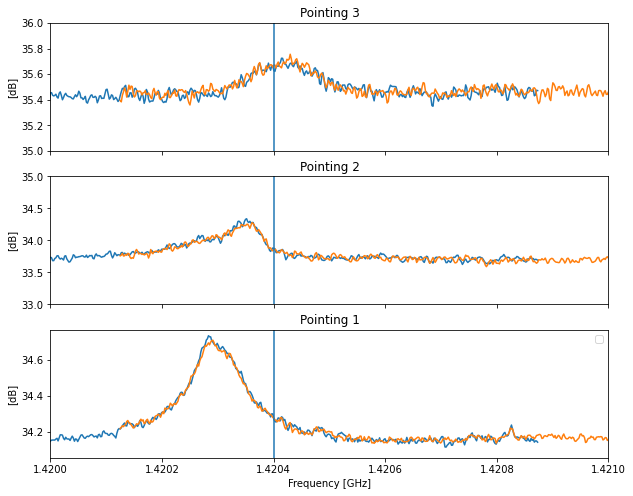

In [24]:
plt.figure()
fig,axs = plt.subplots(ntrials, 1, sharex=True, figsize=(10,8))
for j in range(ntrials):
    for f, s in zip(freqs[j], spectra[j]):
        axs[j].plot(f, s)
    if j==0:
        axs[j].set_title('Pointing 3')
        axs[j].set_ylim(35,36)
    if j==1:
        axs[j].set_title('Pointing 2')
        axs[j].set_ylim(33,35)
    if j==2:
        axs[j].set_title('Pointing 1')


    axs[j].set_ylabel('[dB]')
    axs[j].axvline(1.4204)
    #plot_f0(lims=[37, 39])
plt.xlim(1.42,1.421)   
plt.legend()
plt.xlabel('Frequency [GHz]')
plt.xlabel('Frequency [GHz]')

# Comparison to Survey Data

## Pointing 2

In [7]:
#location = EarthLocation.from_geodetic(-91.64, 44.048708, 200*u.m) #Winona Lon, Lat, elevation
#location = location.get_itrs(obstime=Time('2022-10-08T18:25:00')) #To ITRS frame, makes Earth stationary with Sun 
#pointing_45deg = SkyCoord('19h 47m20.6s','10d40m12.1s', frame='icrs') #Center of CHART pointing
#frequency = SpectralCoord(1.420405751768e9 * u.Hz, observer=location, target=pointing_45deg) #Shift expected from just local motion
#f0_shifted = frequency.with_observer_stationary_relative_to('lsrk') #correct for kinematic local standard of rest
#f0_shifted = f0_shifted.to(u.GHz)
#v = doppler(f0_shifted,f0)
#v_adjustment = v.to(u.km/u.second)
#print(v_adjustment)
v_adjustment = 0


Insert name of your file where it says (input). Do not add the parenthesis.

In [11]:
sh_comp = pd.read_table('HI_profiles_comparison/(input)',skiprows=[0,1,2,3],names=['v_lsr', 'T_B', 'freq', 'wavel'], delimiter = '\s+')



Text(0.5, 1.0, 'CHART HI Profile and Model Profile for l=48 and b=-7 degrees')

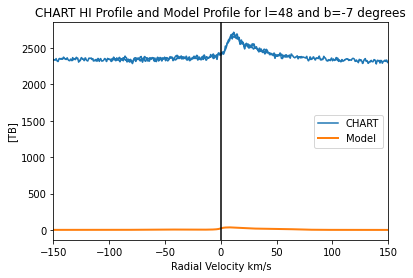

In [12]:
j = 1
fig, ax1 = plt.subplots()

compTB = sh_comp['T_B']

noise=0
gain=1

#noise = 2315
#gain = max(10**(spectra[j][11]/10)-2315)/(max(compTB))

for k in range(10,12):
    velocity = f2v(freqs[j][k]*u.GHz) / 1000
    if k==10:
        ax1.plot(velocity*(u.kilometer)/(u.second)-v_adjustment, (10**(spectra[j][k]/10)- noise)/gain, 'tab:blue',  label = 'CHART')
    if k==11:
        ax1.plot(velocity*(u.kilometer)/(u.second)-v_adjustment, (10**(spectra[j][k]/10) - noise)/gain,'tab:blue')


ax1.plot(sh_comp['v_lsr'],compTB,'tab:orange', linewidth=2, label = 'Model')


plt.axvline(0, color ='k')

ax1.set_ylabel('[TB]')

plt.xlim(-150,150)
ax1.legend(loc='best')
plt.xlabel('Radial Velocity km/s')
plt.title('CHART HI Profile and Model Profile for l=48 and b=-7 degrees')

# Pointing 3

In [13]:
#location = EarthLocation.from_geodetic(-91.64, 44.048708, 200*u.m) #Winona Lon, Lat, elevation
#location = location.get_itrs(obstime=Time('2022-10-08T18:00:00')) #To ITRS frame, makes Earth stationary with Sun 
#pointing_45deg = SkyCoord('19h45m41.8s','45d11m16.4s', frame='icrs') #Center of CHART pointing
#frequency = SpectralCoord(1.420405751768e9 * u.Hz, observer=location, target=pointing_45deg) #Shift expected from just local motion
#f0_shifted = frequency.with_observer_stationary_relative_to('lsrk') #correct for kinematic local standard of rest
#f0_shifted = f0_shifted.to(u.GHz)
#v = doppler(f0_shifted,f0)
#v_adjustment = v.to(u.km/u.second)
#print(v_adjustment)
v_adjustment=0

Insert name of your file where it says (input). Do not add the parenthesis.

In [19]:
sh_comp = pd.read_table('HI_profiles_comparison/(input)',skiprows=[0,1,2,3],names=['v_lsr', 'T_B', 'freq', 'wavel'], delimiter = '\s+')

FileNotFoundError: [Errno 2] No such file or directory: 'HI_profiles_comparison/(input)'

Text(0.5, 1.0, 'CHART HI Profile and Model Profile for l=90 and b=0 degrees')

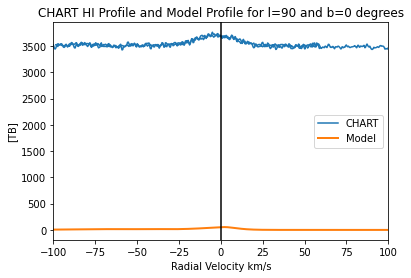

In [15]:
j = 0

fig, ax1 = plt.subplots()

compTB = sh_comp['T_B']

noise = 0
gain = 1

#noise = 3475
#gain = max(10**(spectra[j][31]/10)-3475)/(max(compTB))

for k in range(30,32):
    velocity = f2v(freqs[j][k]*u.GHz) / 1000
    if k == 30:
        ax1.plot(velocity*(u.kilometer)/(u.second)-v_adjustment, (10**(spectra[j][k]/10)- noise)/gain ,'tab:blue', label = 'CHART')
    else:
        ax1.plot(velocity*(u.kilometer)/(u.second)-v_adjustment, (10**(spectra[j][k]/10) - noise)/gain,'tab:blue')

ax1.plot(sh_comp['v_lsr'],compTB, 'tab:orange',linewidth=2, label = 'Model')


plt.axvline(0, color = 'k')

ax1.set_ylabel('[TB]')
plt.xlim(-100,100)
ax1.legend(loc = 'best')

plt.xlabel('Radial Velocity km/s')
plt.title('CHART HI Profile and Model Profile for l=90 and b=0 degrees')

# Pointing 1

In [16]:
#location = EarthLocation.from_geodetic(-91.64, 44.048708, 200*u.m) #Winona Lon, Lat, elevation
#location = location.get_itrs(obstime=Time('2022-10-08T18:30:00')) #To ITRS frame, makes Earth stationary with Sun 
#pointing_45deg = SkyCoord('ra','dec', frame='icrs') #Center of CHART pointing
#frequency = SpectralCoord(1.420405751768e9 * u.Hz, observer=location, target=pointing_45deg) #Shift expected from just local motion
#f0_shifted = frequency.with_observer_stationary_relative_to('lsrk') #correct for kinematic local standard of rest
#f0_shifted = f0_shifted.to(u.GHz)
#v = doppler(f0_shifted,f0)
#v_adjustment = v.to(u.km/u.second)
#print(v_adjustment)
v_adjustment = 0

Insert name of your file where it says (input). Do not add the parenthesis.

In [17]:
sh_comp = pd.read_table('HI_profiles_comparison/(input)',skiprows=[0,1,2,3],names=['v_lsr', 'T_B', 'freq', 'wavel'], delimiter = '\s+')

Text(0.5, 1.0, 'CHART HI Profile and Model Profile for l=14 and b=-27 degrees')

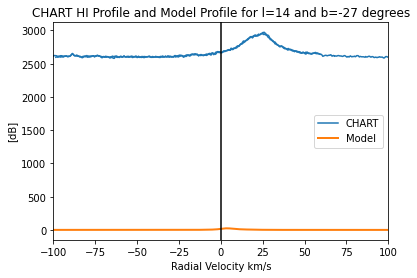

In [18]:
j = 2

fig, ax1 = plt.subplots()
compTB = sh_comp['T_B']

gain = 1
noise = 0
#noise = 2600
#gain = max(10**(spectra[j][0]/10)-2600)/(max(compTB))

for k in range(len(freqs[j])):
    velocity = f2v(freqs[j][k]*u.GHz) / 1000
    if k==0:
        ax1.plot(velocity*(u.kilometer)/(u.second)-v_adjustment, (10**(spectra[j][k]/10)-noise)/gain, 'tab:blue',  label = 'CHART')
    else:
        ax1.plot(velocity*(u.kilometer)/(u.second)-v_adjustment, (10**(spectra[j][k]/10)-noise)/gain, 'tab:blue')
spec = spectra[j][0]

ax1.plot(sh_comp['v_lsr'],compTB,'tab:orange',linewidth=2, label = 'Model')


plt.axvline(0, color='k')
plt.xlim(-100,100)
ax1.set_ylabel('[dB]')

ax1.legend(loc = 'best')

plt.xlabel('Radial Velocity km/s')
plt.title('CHART HI Profile and Model Profile for l=14 and b=-27 degrees')